In [37]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import qgrid
from itertools import chain
import datetime
import ast
import warnings
warnings.filterwarnings('ignore')

In [24]:
root = r'C:\Users\samantha.kuzma\OneDrive - World Resources Institute'

# - - - FOLDERS - - -  - - -  - - - #
# ReservoirWatch/ Power4Water
data_root = os.path.join(root, "ReservoirWatch", "Data") # main data folder
# Untouched copies of raw data
raw_path = os.path.join(data_root, "Raw") # Raw folder
cwc_path = os.path.join(raw_path, "CWC") # CWC reservoir levels 2000 through Jan 2021
# Processed data used in analysis 
analysis_path = os.path.join(data_root, "Analysis") # Analysis folder
rs_path = os.path.join(analysis_path, "RemotelySensed")
context_gdb = os.path.join(analysis_path, "contextual.gdb") # Locally saved spatial data
res_ids_path = os.path.join(analysis_path, "reservoir_to_IDs_lookup.csv")# Matches each reservoir to basins (containing, upstream, downstream)

# Month lookup dictionary
month = {1: "Jan", 2: "Feb", 3: "March", 4: "April", 5: "May", 6: "June",
         7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}

In [56]:
df_res = pd.read_csv(res_ids_path, header = 0, index_col = 0)
df_res

,CWC_NAME,PFAF_ID,HYBAS_ID,GID_2,MAJ_BAS,SUB_BAS,PFAF_UP,PFAF_DN,SUB_UP,SUB_DN
GRAND_ID,,,,,,,,,,
4857,Tilaiya,[453146],[4060963930.0],['IND.15.10_1'],[5036],[36002],[],"[453141, 453143, 453145]",[],[]
4858,Rihand,[452438],[4060903120.0],"['IND.19.46_1', 'IND.34.72_1']",[5035],[35031],[],"[452100, 452300, 452411, 452413, 452415, 45241...",[35030],"[35029, 35032, 35034, 35046, 35048, 35084]"
4862,Maithon,[453146],[4060963930.0],"['IND.36.3_1', 'IND.15.11_1', 'IND.15.4_1']",[5036],[36002],[],"[453141, 453143, 453145]",[],[]
4863,Tenughat,[453149],[4060961650.0],"['IND.15.20_1', 'IND.15.1_1']",[5036],[36002],[],"[453141, 453143, 453145, 453147]",[],[]
4865,Panchet,[453147],[4060964080.0],"['IND.36.18_1', 'IND.15.4_1']",[5036],[36002],"[453148, 453149]","[453141, 453143, 453145]",[],[]
4881,Bargi,[454067],[4060979850.0],"['IND.19.40_1', 'IND.19.27_1', 'IND.19.24_1']",[5048],[48002],"[454068, 454069]","[454061, 454063, 454065]",[48001],"[48004, 48005, 48006, 48007, 48008, 48009, 480..."
4898,Hirakud,"[453230, 453250, 453240]","[4061031590.0, 4061017990.0, 4061017890.0]","['IND.26.4_1', 'IND.26.28_1', 'IND.26.14_1']","[5038, 5038, 5038]","[38005, 38006, 38007]","[453240, 453250, 453260, 453270, 453280, 45329...","[453210, 453230]","[38001, 38002, 38003, 38004, 38005, 38006]","[38007, 38011, 38012]"
4946,Sriramsagar,"[453479, 453477, 453478]","[4061060950.0, 4061061290.0, 4061060870.0]","['IND.32.8_1', 'IND.32.1_1']",[5040],[40010],"[453478, 453479, 453481, 453482, 453483, 45348...","[453410, 453430, 453450, 453471, 453473, 45347...","[40001, 40002, 40003, 40004, 40005, 40006, 400...","[40013, 40020, 40023]"
5014,Mettur,[453805],[4061145690.0],"['IND.31.18_1', 'IND.31.5_1', 'IND.16.8_1']",[5044],[44005],"[453806, 453807, 453808, 453809]","[453801, 453803]","[44001, 44002, 44003, 44004]",[44007]


## List Remotely Sensed data options

In [3]:
rs_data = os.listdir(rs_path)
print(rs_data)

['chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-MEAN_Scale-5000.csv', 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-SUM_Scale-5000.csv', 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-MEAN_Scale-5000.csv', 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-SUM_Scale-5000.csv']


# Functions

In [8]:
def fix_dates(df_in, date_name):
    df_in[date_name] = pd.to_datetime(df_in[date_name]) # Set date as date format
    # Add Day, month, year as unique columns
    df_in['Day'] = df_in[date_name].dt.day
    df_in['Month'] = df_in[date_name].dt.month
    df_in['Year'] = df_in[date_name].dt.year
    return df_in

# Read in remotely sensed data

In [52]:
df_avg = pd.read_csv(os.path.join(rs_path, rs_data[2]), header = 0, index_col = 0)
df_sum = pd.read_csv(os.path.join(rs_path, rs_data[3]), header = 0, index_col = 0)

# Fix dates
df_avg = fix_dates(df_avg, 'date')
df_sum = fix_dates(df_sum, 'date')

In [53]:
df_avg

,PFAF_ID,mean,date,Day,Month,Year
20,452100,6.064835,2000-01-01,1,1,2000
101,452100,13.012936,2000-02-01,1,2,2000
182,452100,54.151577,2000-03-01,1,3,2000
263,452100,230.904454,2000-04-01,1,4,2000
344,452100,558.637012,2000-05-01,1,5,2000
...,...,...,...,...,...,...
20026,454069,602.739106,2020-08-01,1,8,2020
20107,454069,165.431571,2020-09-01,1,9,2020
20188,454069,46.966461,2020-10-01,1,10,2020
20269,454069,11.411580,2020-11-01,1,11,2020


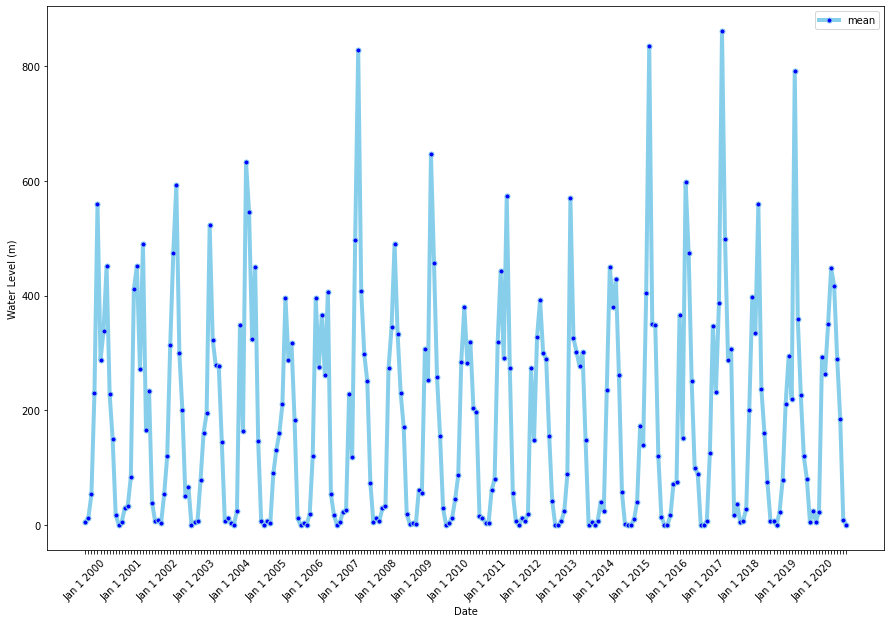

In [54]:
pf = 452100
df_avg_f = df_avg[df_avg.PFAF_ID == pf]
df_sum_f = df_sum[df_sum.PFAF_ID == pf]

daily_stats = df_avg_f.copy()
daily_stats.sort_values(['Year', 'Month', 'Day'], inplace = True)
daily_stats['JD'] = range(0,len(daily_stats)) # Create number sequence for every record
# Create date label, only keep the 1st date per year. Else, too many labels
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][(daily_stats.Day > 1) | (daily_stats.Month > 1)] = ""
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PLOT  - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = daily_stats['JD'].tolist() # Julian day values
my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'mean', data=daily_stats, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# Add legend and labels
plt.legend()
# plt.title("{:s}: Daily Water Levels".format(res))
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
# Show plot
plt.show()


# # # Data
# plt.figure(figsize=(15,10)) 
# # # multiple line plots
# # plt.plot( 'date','mean', data=df_avg, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# # plt.plot( 'date', 'mean', data=df_avg_f, marker='', color='blue', linewidth=2)
# plt.plot( 'date', 'sum', data=df_sum_f, marker='', color='olive', linewidth=2)
# # plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
# # # show legend
# plt.legend()
# plt.title(res)
# # # show graph
# plt.show()

In [42]:
rs_data

['chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-SUM_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-SUM_Scale-5000.csv']

In [50]:
qgrid.show_grid(df_avg_f)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

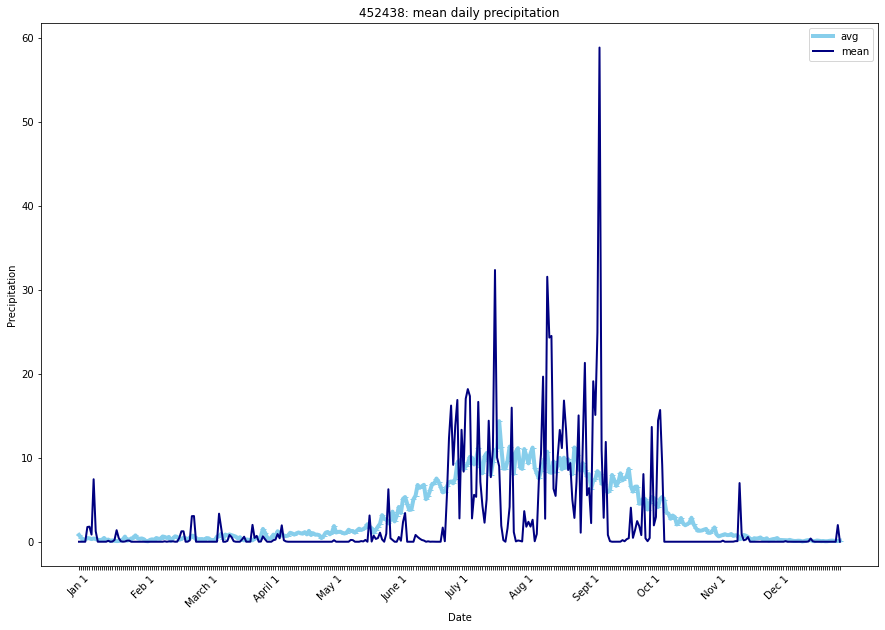

In [80]:
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - SET WATERSHED AND DATES - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Inputs
ts_step = 'day'
zs_stat = 'mean'
pf = 452438
start_date = "01/01/2009"
end_date = "01/01/2010"

# Read in data
file_name = 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-{:s}_IC-sum_ZS-{:s}_Scale-5000.csv'.format(ts_step, zs_stat.upper())
df_avg = pd.read_csv(os.path.join(rs_path, file_name), header = 0, index_col = 0)
# Fix dates
df_avg = fix_dates(df_avg, 'date')
df_avg_f = df_avg[(df_avg.PFAF_ID == pf)]
df_f = df_avg_f[(df_avg.date >= start_date) & (df_avg.date < end_date)]
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - CLEAN UP DATE LABEL  - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_f.sort_values(['Year', 'Month', 'Day'], inplace = True)
df_f['JD'] = range(0,len(df_f)) # Create number sequence for every record
# Create date label, only keep the 1st date per year. Else, too many labels
df_f['JD_Text'] = df_f.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])) + " " + str(int(x['Year'])), axis = 1)
df_f['JD_Text_Clean']= df_f['JD_Text']
df_f['JD_Text_Clean'][(df_f.Day > 1) | (df_f.Month > 1)] = ""
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - FIND DAILY AVERAGE  - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Find min, max and average values per Julian date
dmin = df_avg.groupby(['Day', 'Month'])[zs_stat].min()
dmax = df_avg.groupby(['Day', 'Month'])[zs_stat].max()
dmean = df_avg.groupby(['Day', 'Month'])[zs_stat].mean()
# Add stats to 1 dataframe, sort by day of the year
daily_stats = pd.DataFrame(data = {'min': dmin, 'max': dmax, "avg": dmean}).reset_index()
daily_stats.sort_values(['Month', 'Day'], inplace = True)
daily_stats = daily_stats[~((daily_stats.Month ==2) & (daily_stats.Day ==29)) ]

# Create Julian Day #
daily_stats['JD'] = range(0,365)
# Create Date label with month and day to make it easier to read axis
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])), axis = 1)
# Only keep the label for the 1st of every month. Else too many labels to read
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][daily_stats.Day > 1] = ""
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - PLOT  - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Data
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = daily_stats['JD'].tolist() # Julian day values
my_xticks = daily_stats['JD_Text_Clean'].tolist() #Julain day labels
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'avg', data=daily_stats, marker='_', color='skyblue', linewidth=4)
plt.plot( 'JD', zs_stat, data=df_f, marker='', color='navy', linewidth=2)
# Add legend and labels
plt.legend()
plt.title("{:s}: {:s} daily precipitation".format(str(pf), zs_stat))
plt.xlabel('Date')
plt.ylabel('Precipitation')
# Show plot
plt.show()


In [31]:
# Find min, max and average values per Julian date
dmin = df_avg.groupby(['Day', 'Month'])['mean'].min()
dmax = df_avg.groupby(['Day', 'Month'])['mean'].max()
dmean = df_avg.groupby(['Day', 'Month'])['mean'].mean()
# Add stats to 1 dataframe, sort by day of the year
daily_stats = pd.DataFrame(data = {'min': dmin, 'max': dmax, "avg": dmean}).reset_index()
daily_stats.sort_values(['Month', 'Day'], inplace = True)
# Create Julian Day #
daily_stats['JD'] = range(0,366)
# Create Date label with month and day to make it easier to read axis
daily_stats['JD_Text'] = daily_stats.apply(lambda x: month.get(x['Month']) + " " + str(int(x['Day'])), axis = 1)
# Only keep the label for the 1st of every month. Else too many labels to read
daily_stats['JD_Text_Clean']= daily_stats['JD_Text']
daily_stats['JD_Text_Clean'][daily_stats.Day > 1] = ""

<ipython-input-31-a9e772a07f98>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_stats['JD_Text_Clean'][daily_stats.Day > 1] = ""


In [74]:
daily_stats

,Day,Month,min,max,avg,JD,JD_Text,JD_Text_Clean
0,1,1,0.0,21.682213,0.807844,0,Jan 1,Jan 1
12,2,1,0.0,35.881070,0.475514,1,Jan 2,
24,3,1,0.0,24.624827,0.256349,2,Jan 3,
36,4,1,0.0,5.869952,0.271857,3,Jan 4,
48,5,1,0.0,8.383883,0.438737,4,Jan 5,
...,...,...,...,...,...,...,...,...
323,27,12,0.0,14.426419,0.130470,360,Dec 27,
335,28,12,0.0,18.043078,0.115947,361,Dec 28,
347,29,12,0.0,13.229453,0.082478,362,Dec 29,
358,30,12,0.0,10.014011,0.080006,363,Dec 30,


In [76]:
qgrid.show_grid(df_f)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [111]:
df_avg['cs'] = df_avg.groupby(['PFAF_ID', 'Year'])['mean'].cumsum()
df_avg_f = df_avg[(df_avg.PFAF_ID == pf)]

In [116]:
df_avg_f['ord'] = df_avg_f['date'].apply(lambda x: x.toordinal())
df_year = df_avg_f[['Year', 'ord']][(df_avg_f.Month ==1) & (df_avg_f.Day ==1)].set_index(['Year'])
df_j = pd.merge(df_avg_f, df_year, how = 'left', left_on = 'Year', right_index = True)
df_j['JD'] = df_j['ord_x'] - df_j['ord_y'] 

In [142]:
df_j = pd.merge(df_avg_f, df_year, how = 'left', left_on = 'Year', right_index = True)
df_j['JD'] = df_j['ord_x'] - df_j['ord_y'] 
df_lvls = pd.pivot_table(df_j, values="cs", index="JD", columns="Year", aggfunc='mean', fill_value=0)
df_lvls = df_lvls.add_prefix('y')
df_lvls = df_lvls.iloc[0:-1]
# df_lvls.replace(0, np.nan, inplace = True)

In [144]:
qgrid.show_grid(df_lvls)

,PFAF_ID,mean,date,Day,Month,Year,cumsum,cs,ord_x,ord_y,JD
80,452438,0.000000,2000-01-01,1,1,2000,0.000000,0.000000,730120,730120,0
161,452438,0.047400,2000-01-02,2,1,2000,0.047400,0.047400,730121,730120,1
242,452438,1.903432,2000-01-03,3,1,2000,1.950832,1.950832,730122,730120,2
323,452438,3.486765,2000-01-04,4,1,2000,5.437597,5.437597,730123,730120,3
404,452438,3.498091,2000-01-05,5,1,2000,8.935689,8.935689,730124,730120,4
...,...,...,...,...,...,...,...,...,...,...,...
621026,452438,0.118930,2020-12-27,27,12,2020,1402.378290,1402.378290,737786,737425,361
621107,452438,0.019643,2020-12-28,28,12,2020,1402.397934,1402.397934,737787,737425,362
621188,452438,0.000000,2020-12-29,29,12,2020,1402.397934,1402.397934,737788,737425,363
621269,452438,0.000000,2020-12-30,30,12,2020,1402.397934,1402.397934,737789,737425,364


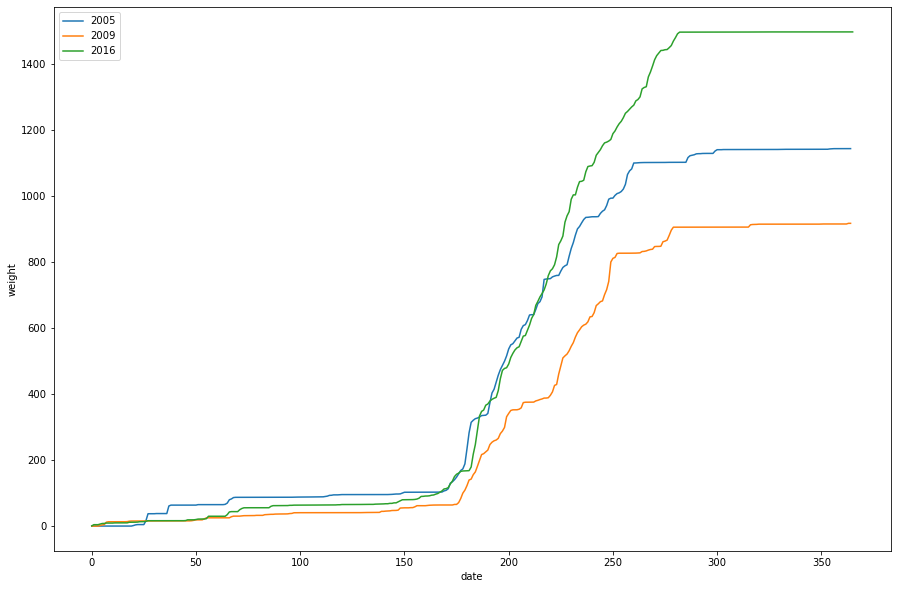

In [133]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,10))

for year in [2005, 2009, 2016]:
    ax.plot(df_j[df_j.Year==year].JD,df_j[df_j.Year==year].cs,label=year)

    
ax.set_xlabel("date")
ax.set_ylabel("weight")
ax.legend(loc='best')

In [113]:
df_avg_f.cs

80           0.000000
161          0.047400
242          1.950832
323          5.437597
404          8.935689
             ...     
621026    1402.378290
621107    1402.397934
621188    1402.397934
621269    1402.397934
621350    1402.408419
Name: cs, Length: 7671, dtype: float64

In [109]:
qgrid.show_grid(df_avg_f)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

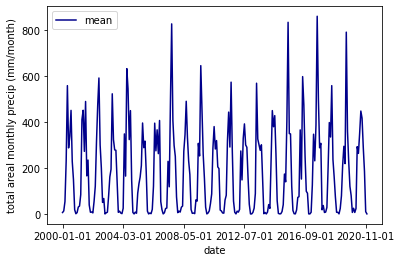

<Figure size 1080x720 with 0 Axes>

In [145]:
ax=df_sum_f.plot(kind='line', x='date', y='sum', secondary_y=True,color='Red', ax=ax)

ax2=df_avg_f.plot(kind='line', x='date', y='mean', color='DarkBlue')


ax.set_ylabel('mean areal monthly precip (mm/month)')
ax2.set_ylabel('total areal monthly precip (mm/month)')

plt.figure(figsize=(15,10)) 
plt.tight_layout()
plt.show()

In [141]:
np.unique(df_avg.PFAF_ID.tolist())

array([452100, 452300, 452411, 452413, 452415, 452417, 452419, 452431,
       452433, 452435, 452437, 452438, 453141, 453143, 453145, 453146,
       453147, 453148, 453149, 453210, 453230, 453240, 453250, 453260,
       453270, 453280, 453291, 453292, 453293, 453294, 453295, 453296,
       453297, 453298, 453299, 453410, 453430, 453450, 453461, 453463,
       453464, 453471, 453473, 453475, 453477, 453478, 453479, 453481,
       453482, 453483, 453484, 453485, 453486, 453487, 453488, 453489,
       453491, 453492, 453493, 453494, 453495, 453496, 453497, 453498,
       453499, 453801, 453803, 453805, 453806, 453807, 453808, 453809,
       454061, 454062, 454063, 454064, 454065, 454066, 454067, 454068,
       454069])

In [4]:
# READ IN LOOKUP TABLE
df_lookup = pd.read_csv(res_ids_path, header = 0, index_col = None)
# Make sure lists are lists, not strings
df_lookup['PFAF_ID'] = df_lookup['PFAF_ID'].apply(lambda x: ast.literal_eval(x))
df_lookup['PFAF_UP'] = df_lookup['PFAF_UP'].apply(lambda x: ast.literal_eval(x))
df_lookup['PFAF_DN'] = df_lookup['PFAF_DN'].apply(lambda x: ast.literal_eval(x))
# Find basins per reservoir
res = 'Rihand'
res_withs = df_lookup['PFAF_ID'][df_lookup.CWC_NAME == res].values[0]
res_ups = df_lookup['PFAF_UP'][df_lookup.CWC_NAME == res].values[0]
res_downs = df_lookup['PFAF_DN'][df_lookup.CWC_NAME == res].values[0]

In [93]:
# Read in CHIRPS data
df_chirps = pd.read_csv('daily_chirps_201801-202012.csv', header = 0, index_col = 0)
df_chirps['date'] = pd.to_datetime(df_chirps['date'])
daily_precip = df_chirps[df_chirps.PFAF_ID.isin(res_withs)]

In [94]:
# Read in CWC data
res_cwc = os.path.join(cwc_path, res, "{}_00_21.csv".format(res))
df_cwc = pd.read_csv(res_cwc, header = 1)
df_cwc['Dates'] = pd.to_datetime(df_cwc['Dates'])
# print(res_cwc)

start_date = datetime.date(2017,11,1)
end_date = datetime.date(2019,12,1)

df_cwc_f = df_cwc[df_cwc.Dates.isin(pd.date_range(start_date, end_date))]

In [74]:

daily_precip

,PFAF_ID,mean,date
80,452438,13.484026,2020-01-01
161,452438,7.721196,2020-01-02
242,452438,1.343628,2020-01-03
323,452438,0.000000,2020-01-04
404,452438,0.000000,2020-01-05
...,...,...,...
7046,452438,0.012021,2020-03-27
7127,452438,0.000000,2020-03-28
7208,452438,0.000000,2020-03-29
7289,452438,0.000000,2020-03-30


In [43]:

x = ast.literal_eval(x)

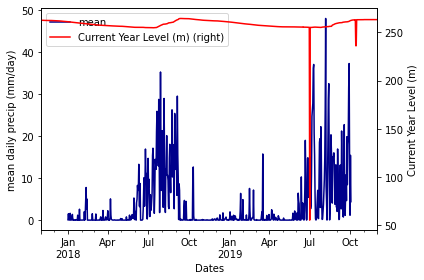

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.DataFrame({'Age': [22, 12, 18, 25, 30],
#                    'Height': [155,129,138,164,145],
#                    'Weight': [60,40,45,55,60]})
ax=daily_precip.plot(kind='line', x='date', y='mean', color='DarkBlue')

ax2=df_cwc_f.plot(kind='line', x='Dates', y='Current Year Level (m)', secondary_y=True,color='Red', ax=ax)

ax.set_ylabel('mean daily precip (mm/day)')
ax2.set_ylabel('Current Year Level (m)')
plt.tight_layout()
plt.show()

In [106]:
df_lookup.CWC_NAME.tolist()

['Tilaiya',
 'Rihand',
 'Maithon',
 'Tenughat',
 'Panchet',
 'Bargi',
 'Hirakud',
 'Sriramsagar',
 'Mettur',
 'indirasagar',
 'Pench']

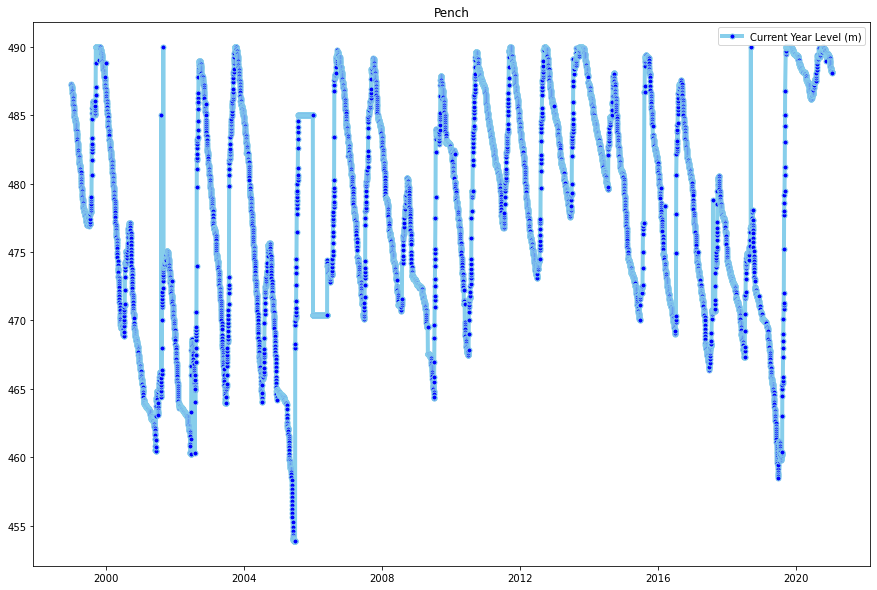

In [5]:
reses = df_lookup.CWC_NAME.tolist()
res = reses[10]
# Read in CWC data
res_cwc = os.path.join(cwc_path, res, "{}_00_21.csv".format(res))
df_cwc = pd.read_csv(res_cwc, header = 1)
df_cwc['Dates'] = pd.to_datetime(df_cwc['Dates'])
 
# # Data
# df=pd.DataFrame({'x_values': range(1,11), 'y1_values': np.random.randn(10), 'y2_values': np.random.randn(10)+range(1,11), 'y3_values': np.random.randn(10)+range(11,21) })
plt.figure(figsize=(15,10)) 
# # multiple line plots
plt.plot( 'Dates','Current Year Level (m)', data=df_cwc, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=4)
# plt.plot( 'date', 'mean', data=daily_precip, marker='', color='olive', linewidth=2)
# plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
# # show legend
plt.legend()
plt.title(res)
# # show graph
plt.show()

In [6]:
df_cwc

,Dates,Current Year Level (m),Last Year Level (m),Last 10 Year Average Level (m),Full Reservoir Level,Last 10 Year Average Storage (BCM),Last Year Storage (BCM),Current Year Storage (BCM)
0,1999-01-01,487.26,0.00,487.260,490,0.8910,0.000,0.891
1,1999-01-02,487.20,0.00,487.200,490,0.8870,0.000,0.887
2,1999-01-03,487.16,0.00,487.160,490,0.8840,0.000,0.884
3,1999-01-04,487.10,0.00,487.100,490,0.8800,0.000,0.880
4,1999-01-05,487.00,0.00,487.000,490,0.8770,0.000,0.877
...,...,...,...,...,...,...,...,...
7798,2021-01-14,488.19,489.37,481.323,490,0.5390,0.968,0.880
7799,2021-01-15,488.18,489.36,481.279,490,0.5371,0.967,0.880
7800,2021-01-16,488.18,489.35,481.235,490,0.5349,0.966,0.880
7801,2021-01-17,488.17,489.35,481.194,490,0.5333,0.966,0.879


In [123]:
reses = df_lookup.CWC_NAME.tolist()
for res in reses:
    print(res)
    # Read in CWC data
    res_cwc = os.path.join(cwc_path, res, "{}_00_21.csv".format(res))
    df_cwc = pd.read_csv(res_cwc, header = 1)
    df_cwc['Dates'] = pd.to_datetime(df_cwc['Dates'])
    print(" - - - -DATES - - - -")
    print(df_cwc['Dates'].min())
    print(df_cwc['Dates'].max())
    print(" - - - -LEVELS - - - -")
    print(df_cwc['Current Year Level (m)'].min())
    print(df_cwc['Current Year Level (m)'].max())
    

Tilaiya
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-22 00:00:00
 - - - -LEVELS - - - -
346.03
368.81
Rihand
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-14 00:00:00
 - - - -LEVELS - - - -
55.18
268.01
Maithon
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-22 00:00:00
 - - - -LEVELS - - - -
122.8
146.3
Tenughat
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-22 00:00:00
 - - - -LEVELS - - - -
250.45
263.32
Panchet
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-22 00:00:00
 - - - -LEVELS - - - -
102.81
124.97
Bargi
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-14 00:00:00
 - - - -LEVELS - - - -
146.1
422.76
Hirakud
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-12 00:00:00
 - - - -LEVELS - - - -
92.01
192.02
Sriramsagar
 - - - -DATES - - - -
2000-02-01 00:00:00
2021-01-20 00:00:00
 - - - -LEVELS - - - -
318.06
332.54
Mettur
 - - - -DATES - - - -
2000-01-01 00:00:00
2021-01-20 00:00:00
 - - - -LEVELS - - - -
204.222
240.79
indirasagar
 - - - -DATES - - - -
2003-0

In [121]:
df_cwc['Dates'].min()

Timestamp('1999-01-01 00:00:00')

In [147]:
# import pymannkendall as mk
mk.original_test(df_j['mean'].tolist())

Mann_Kendall_Test(trend='increasing', h=True, p=6.8833827526759706e-15, z=7.78755472828417, Tau=0.05743927628683997, s=1689765.0, var_s=47081455803.0, slope=0.0, intercept=0.035699152693314)

In [148]:
df_j

,PFAF_ID,mean,date,Day,Month,Year,cumsum,cs,ord_x,ord_y,JD
80,452438,0.000000,2000-01-01,1,1,2000,0.000000,0.000000,730120,730120,0
161,452438,0.047400,2000-01-02,2,1,2000,0.047400,0.047400,730121,730120,1
242,452438,1.903432,2000-01-03,3,1,2000,1.950832,1.950832,730122,730120,2
323,452438,3.486765,2000-01-04,4,1,2000,5.437597,5.437597,730123,730120,3
404,452438,3.498091,2000-01-05,5,1,2000,8.935689,8.935689,730124,730120,4
...,...,...,...,...,...,...,...,...,...,...,...
621026,452438,0.118930,2020-12-27,27,12,2020,1402.378290,1402.378290,737786,737425,361
621107,452438,0.019643,2020-12-28,28,12,2020,1402.397934,1402.397934,737787,737425,362
621188,452438,0.000000,2020-12-29,29,12,2020,1402.397934,1402.397934,737788,737425,363
621269,452438,0.000000,2020-12-30,30,12,2020,1402.397934,1402.397934,737789,737425,364
